In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [145]:
df = pd.read_csv('cl_data.csv')

In [146]:
df['high_white'].value_counts()


0    15369
1    15203
Name: high_white, dtype: int64

In [147]:
url_pattern = r'https?:\/\/(www).*[\r\n]*'

In [148]:
punctuation_pattern = r"[\w'-]+|[.,!?;]+"

In [149]:
def preprocess(text):
    no_urls = re.sub(url_pattern, '', text)
    tokenized = re.findall(punctuation_pattern, no_urls)
    return ' '.join([word.lower() for word in tokenized])

In [150]:
df['body_text'] = df['body_text'].apply(preprocess)

In [151]:
df.loc[0]['body_text']

'special offer save up to off move-in costs this perfect one bedroom home with a den could be your perfect match ! located on the first floor , this home offers a stellar view of greenery , and an electric fireplace ! walk in closet in the bedroom , a size-able den , hallway coat closet , and an outdoor storage closet on your private patio ! located in the heart of mill creek within walking distance to everything you could possibly need ! easy access to freeways , shopping , and dining ! office hours monday am - pm tuesday am - pm wednesday am - pm thursday am - pm friday am - pm saturday am - pm sunday closed monterra in mill creek apartments more photos our community does not accept reusable tenant screening reports .'

In [152]:
X_train, X_test, y_train, y_test = train_test_split(df['body_text'], df['high_white'], random_state=0)

In [153]:
ngram_vectorizer = CountVectorizer(ngram_range=(1,4)).fit(X_train)

In [154]:
ngram_vectorizer.get_feature_names()

['__',
 '__ __',
 '__ __ __',
 '__ __ __ affordable',
 '__ __ affordable',
 '__ __ affordable housing',
 '__ affordable',
 '__ affordable housing',
 '__ affordable housing maximum',
 '_______',
 '_______ _______',
 '_______ _______ _______',
 '_______ _______ _______ people',
 '_______ _______ _______ unit',
 '_______ _______ people',
 '_______ _______ people _______',
 '_______ _______ unit',
 '_______ _______ unit price',
 '_______ people',
 '_______ people _______',
 '_______ people _______ _______',
 '_______ unit',
 '_______ unit price',
 '_______ unit price __',
 '___________________________',
 '___________________________ application',
 '___________________________ application fee',
 '___________________________ application fee non',
 '___________________________ cleaning',
 '___________________________ cleaning fee',
 '___________________________ cleaning fee non',
 '___________________________ tenant',
 '___________________________ tenant responsible',
 '______________________

In [155]:
word_vectorizer = CountVectorizer()

In [156]:
word_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [157]:
word_vectorizer.get_feature_names()

['__',
 '_______',
 '___________________________',
 '_____________________________',
 '___________________________________',
 '_______________________________________',
 '________________________________________',
 '____________________________________________',
 '_______________________________________________',
 '________________________________________________',
 '__________________________________________________',
 '_____________________________________________________',
 '____________________________________________________________',
 '______________________________________________________________________',
 '___________________________________________________________________________',
 '_____________________________________________________________________________',
 '_______________________________________________________________________________',
 '_____________________________________________________________________________________',
 '_________________________________________

In [158]:
X_train_vectorized = word_vectorizer.transform(X_train)

In [159]:
# Logistic regression model
model = LogisticRegression(C=.1).fit(X_train_vectorized, y_train)

In [161]:
predictions = model.predict_proba(word_vectorizer.transform(X_test))[:,1]

In [162]:
predictions

array([0.3751804 , 0.90276181, 0.99430572, ..., 0.73065096, 0.98536629,
       0.84365366])

In [169]:
binary_pred = [0 if value <= 0.5 else 1 for value in predictions]

In [170]:
print('AUC: ', roc_auc_score(y_test, predictions))
print('F1 score: ', f1_score(y_test, binary_pred))
print('accuracy: ', accuracy_score(y_test, binary_pred))

AUC:  0.9587153352170561
F1 score:  0.9046632124352332
accuracy:  0.9037027345283266


In [166]:
predictions

array([0.3751804 , 0.90276181, 0.99430572, ..., 0.73065096, 0.98536629,
       0.84365366])

In [171]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

(0.0, 1.0)

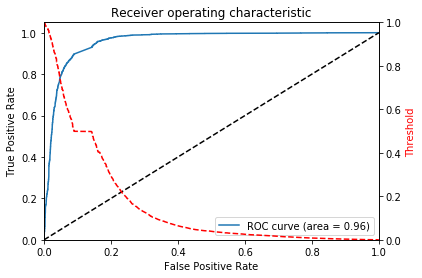

In [172]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

In [173]:
feature_names = np.array(word_vectorizer.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['renton' 'redmond' 'federal' 'kent' 'henry' 'moda' 'pioneer' 'lakewood'
 'seeley' 'airport' 'rianna' 'bellevue' 'hubbard' 'columbia' 'westwood'
 'mall' 'beacon' 'heronfield' 'alderwood' 'modera']

Largest Coefs: 
['sage' 'covington' 'merrill' 'shoreline' 'lofts' 'retreat' 'capital'
 'fairways' 'marq' 'llc' 'greenlake' 'samm' 'northshore' 'capitol'
 'olivian' 'kirkland' 'bradford' 'ballard' 'puyallup' 'olympia']


In [174]:
# lol. keeping in the neighborhood names is too useful lmao
